In [ ]:
# Check GPU status
!nvidia-smi


Tue Aug 20 20:12:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
from sklearn.preprocessing import LabelEncoder


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns
from sklearn.manifold import TSNE


# torch geometrics
import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
# # Grape

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# # Grape
# from grape.datasets import get_all_available_graphs_dataframe
# from grape.datasets import get_dataset
from grape import Graph
from grape import GraphVisualizer

# # Ensmallen
# from grape.embedders import Node2VecCBOWEnsmallen, Node2VecGloVeEnsmallen, Node2VecSkipGramEnsmallen
# from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
# from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
# from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
# #from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen
from grape.embedders import TransEEnsmallen

# # TensorFlow
# from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
# from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# # KarateClub
# from grape.embedders import Role2VecKarateClub, GraRepKarateClub
# from grape.embedders import NMFADMMKarateClub, RandNEKarateClub


# # Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
# from grape.node_label_prediction import node_label_prediction_evaluation
# from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load graph
view=5
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [ ]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [ ]:
# IMPORT METHODS

# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [ ]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [ ]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

# train_data = Data(x=nodes_x,
#                   edge_index=edge_index, edge_type=edge_type,
#                   edge_label_index=edge_index,
#                   edge_label=torch.ones(edge_index.size(1))
#                     )

# train_data = train_data.to(device)

In [ ]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

transform = RandomLinkSplit(is_undirected=False)

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

In [ ]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1590078  Test:454306  Validation: 227152


In [ ]:
# Model

model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50, # The hidden embedding size.
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6)

# ALTERNATIVE MODELS

# model_map = {
#     'transe': TransE,
#     'complex': ComplEx,
#     'distmult': DistMult,
#     'rotate': RotatE,
# }

# Proposed configurations
# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }

In [ ]:
# Training definitions

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

In [ ]:
# Training
n_epochs=52

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6917
Epoch: 003, Loss: 0.6885
Epoch: 004, Loss: 0.6841
Epoch: 005, Loss: 0.6790
Epoch: 006, Loss: 0.6734
Epoch: 007, Loss: 0.6674
Epoch: 008, Loss: 0.6610
Epoch: 009, Loss: 0.6545
Epoch: 010, Loss: 0.6479
Epoch: 011, Loss: 0.6413
Epoch: 012, Loss: 0.6348
Epoch: 013, Loss: 0.6283
Epoch: 014, Loss: 0.6220
Epoch: 015, Loss: 0.6157
Epoch: 016, Loss: 0.6096
Epoch: 017, Loss: 0.6039
Epoch: 018, Loss: 0.5981
Epoch: 019, Loss: 0.5926
Epoch: 020, Loss: 0.5874
Epoch: 021, Loss: 0.5822
Epoch: 022, Loss: 0.5774
Epoch: 023, Loss: 0.5727
Epoch: 024, Loss: 0.5682
Epoch: 025, Loss: 0.5637


 71%|███████   | 561495/795039 [34:19<14:00, 277.89it/s]

In [ ]:
# Training
n_epochs=75

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.4896
Epoch: 002, Loss: 0.4882
Epoch: 003, Loss: 0.4864
Epoch: 004, Loss: 0.4851
Epoch: 005, Loss: 0.4839
Epoch: 006, Loss: 0.4826
Epoch: 007, Loss: 0.4814
Epoch: 008, Loss: 0.4798
Epoch: 009, Loss: 0.4786
Epoch: 010, Loss: 0.4774
Epoch: 011, Loss: 0.4758
Epoch: 012, Loss: 0.4749
Epoch: 013, Loss: 0.4741
Epoch: 014, Loss: 0.4725
Epoch: 015, Loss: 0.4715
Epoch: 016, Loss: 0.4706
Epoch: 017, Loss: 0.4697
Epoch: 018, Loss: 0.4688
Epoch: 019, Loss: 0.4675
Epoch: 020, Loss: 0.4664
Epoch: 021, Loss: 0.4654
Epoch: 022, Loss: 0.4645
Epoch: 023, Loss: 0.4636
Epoch: 024, Loss: 0.4627
Epoch: 025, Loss: 0.4621


100%|██████████| 806015/806015 [47:57<00:00, 280.08it/s]


Epoch: 025, Val Mean Rank: 5500.65, Val MRR: 0.0350, Val Hits@10: 0.0558
Epoch: 026, Loss: 0.4609
Epoch: 027, Loss: 0.4603
Epoch: 028, Loss: 0.4592
Epoch: 029, Loss: 0.4581
Epoch: 030, Loss: 0.4574
Epoch: 031, Loss: 0.4563
Epoch: 032, Loss: 0.4556
Epoch: 033, Loss: 0.4553
Epoch: 034, Loss: 0.4540
Epoch: 035, Loss: 0.4531
Epoch: 036, Loss: 0.4529
Epoch: 037, Loss: 0.4519
Epoch: 038, Loss: 0.4510
Epoch: 039, Loss: 0.4509
Epoch: 040, Loss: 0.4500
Epoch: 041, Loss: 0.4489
Epoch: 042, Loss: 0.4480
Epoch: 043, Loss: 0.4477
Epoch: 044, Loss: 0.4468
Epoch: 045, Loss: 0.4460
Epoch: 046, Loss: 0.4452
Epoch: 047, Loss: 0.4450
Epoch: 048, Loss: 0.4445
Epoch: 049, Loss: 0.4431
Epoch: 050, Loss: 0.4430


100%|██████████| 806015/806015 [48:12<00:00, 278.68it/s]


Epoch: 050, Val Mean Rank: 5441.67, Val MRR: 0.0350, Val Hits@10: 0.0557
Epoch: 051, Loss: 0.4421
Epoch: 052, Loss: 0.4417
Epoch: 053, Loss: 0.4410
Epoch: 054, Loss: 0.4401
Epoch: 055, Loss: 0.4399
Epoch: 056, Loss: 0.4389
Epoch: 057, Loss: 0.4392
Epoch: 058, Loss: 0.4381
Epoch: 059, Loss: 0.4378
Epoch: 060, Loss: 0.4365
Epoch: 061, Loss: 0.4362
Epoch: 062, Loss: 0.4354
Epoch: 063, Loss: 0.4352
Epoch: 064, Loss: 0.4347
Epoch: 065, Loss: 0.4343
Epoch: 066, Loss: 0.4333
Epoch: 067, Loss: 0.4328
Epoch: 068, Loss: 0.4325
Epoch: 069, Loss: 0.4318
Epoch: 070, Loss: 0.4315
Epoch: 071, Loss: 0.4314
Epoch: 072, Loss: 0.4301
Epoch: 073, Loss: 0.4296
Epoch: 074, Loss: 0.4296


In [ ]:
## EXTERNAL TEST SETS

## VIEW 0-2
#test_sets = ['miRNA-disease2bepred']
#test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test-.txt",names=["subject","predicate","object"], sep='\t')

In [ ]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 61], [True, 15679]]


In [ ]:
rank, mrr, hits_at_10 = test(external_test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 15679/15679 [00:56<00:00, 276.19it/s]

Test Mean Rank: 1810.03, Test MRR: 0.0602, Test Hits@10: 0.1577


In [ ]:
node_embedding = pd.DataFrame(model.node_emb.weight.cpu().detach().numpy())

label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))
node_embedding.index = nodes_df
len(node_embedding)

85299

In [ ]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"(<http://www.ncbi.nlm.nih.gov/gene/1163>, Gene)",0.019454,-0.048431,-0.010727,0.047112,-0.036169,0.010635,-0.021835,0.010335,-0.006186,0.025911,...,0.055806,0.029043,0.029542,-0.052032,-0.020035,0.055045,0.004666,0.008001,-0.031917,0.011687
"(<http://purl.obolibrary.org/obo/GO_1902115>, GO)",0.029251,-0.031586,0.024200,-0.011557,0.038311,0.038435,0.062508,0.038829,0.023565,-0.062398,...,0.030214,-0.054478,-0.056289,-0.030296,0.061333,0.031276,-0.021152,-0.022761,0.038475,-0.025494
"(<http://purl.obolibrary.org/obo/MONDO_0009301>, Disease)",0.034207,-0.038086,0.038826,-0.013902,0.043517,0.042458,0.062446,0.042743,0.038228,-0.059685,...,0.033509,-0.049303,-0.051293,-0.033634,0.062199,0.034942,-0.035460,-0.037357,0.046061,-0.040121
"(<http://www.ncbi.nlm.nih.gov/gene/2692>, Gene)",0.032902,-0.051435,-0.022974,0.043112,-0.033500,0.028668,-0.014103,0.028531,-0.000412,0.022251,...,0.059720,0.027756,0.027769,-0.058552,-0.006635,0.055162,-0.001335,0.011799,-0.030872,0.026276
"(<http://purl.obolibrary.org/obo/MONDO_0000535>, Disease)",0.022262,-0.022577,0.030896,-0.021305,0.044498,0.028064,0.050747,0.028110,0.029416,-0.051172,...,0.017766,-0.044712,-0.046255,-0.017652,0.049405,0.018929,-0.027406,-0.029148,0.044854,-0.031969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(<http://purl.obolibrary.org/obo/UBERON_0035110>, Anatomy)",0.039066,-0.039246,0.035505,-0.016457,0.041433,0.048484,0.065912,0.048648,0.036470,-0.062129,...,0.033844,-0.051915,-0.053874,-0.033543,0.066209,0.034661,-0.033930,-0.034923,0.043549,-0.036712
"(<https://www.mirbase.org/mature/MIMAT0002841>, miRNA)",-0.176873,0.195387,-0.115582,-0.208110,0.184800,-0.184767,-0.174969,-0.186635,-0.134675,0.153273,...,-0.200684,0.074408,0.094322,0.195566,-0.180125,-0.192100,0.131971,0.125402,0.121501,0.113437
"(<http://purl.obolibrary.org/obo/CHEBI_36834>, Chemical)",0.032522,-0.035059,0.028838,-0.010044,0.039450,0.042994,0.067330,0.043454,0.029462,-0.066507,...,0.032770,-0.055892,-0.057995,-0.032662,0.066458,0.034327,-0.026616,-0.028195,0.041699,-0.029993
"(<http://purl.obolibrary.org/obo/HP_0500107>, Phenotype)",0.031747,-0.039820,0.044013,-0.015657,0.044618,0.040775,0.061723,0.041101,0.043727,-0.059536,...,0.034072,-0.050332,-0.051963,-0.034572,0.061304,0.034958,-0.041640,-0.042773,0.047595,-0.045160


In [ ]:
!ls -lh


total 8.0K
drwx------ 5 root root 4.0K Aug 19 13:37 drive
drwxr-xr-x 1 root root 4.0K Aug 14 13:23 sample_data


In [ ]:
node_embedding.to_csv('node_embeddings.csv', header=False, index=True, sep=',')

In [ ]:
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

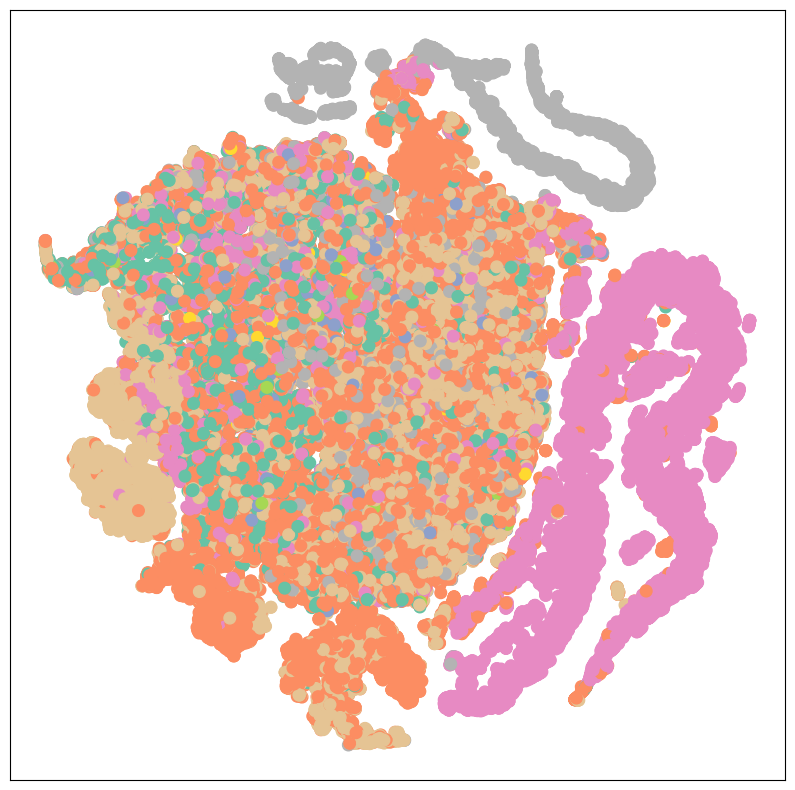

In [ ]:
visualize(node_embedding,node_types)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = node_embedding.values
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6274
Precision: 0.5877
Recall: 0.6274


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [ ]:
node_embedding.values

array([[ 0.01945425, -0.04843133, -0.01072689, ...,  0.00800111,
        -0.03191656,  0.01168713],
       [ 0.02925073, -0.03158612,  0.02420049, ..., -0.02276085,
         0.0384749 , -0.02549376],
       [ 0.03420692, -0.03808551,  0.03882566, ..., -0.03735738,
         0.04606086, -0.04012078],
       ...,
       [ 0.0325225 , -0.03505885,  0.02883788, ..., -0.0281949 ,
         0.04169923, -0.02999298],
       [ 0.03174676, -0.03981976,  0.04401283, ..., -0.04277269,
         0.04759474, -0.04515992],
       [ 0.01794881, -0.06959905, -0.05498191, ...,  0.04545629,
        -0.0985603 ,  0.05909745]], dtype=float32)

In [ ]:
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)



In [ ]:
# Assuming node_embedding index is a tuple of (URI, type)
node_embedding.index = [name[0] for name in node_embedding.index]


In [ ]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embedding.values,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)


Evaluating on VIEW4_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_pickle(filename)

In [ ]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,matthews_correlation_coefficient,prevalence,recall,markedness,fall_out,diagnostic_odds_ratio,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.002295,0.5,0.938901,0.004771,0.937797,1.019268,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.037277,0.5,0.953945,0.082094,0.937018,1.392231,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,-0.000007,0.5,0.946333,-0.000016,0.946336,0.999936,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.031561,0.5,0.959303,0.074262,0.945890,1.348454,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.002843,0.5,0.938166,0.005871,0.936790,1.023764,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.039347,0.5,0.954323,0.086578,0.936441,1.418053,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.003494,0.5,0.936907,0.007141,0.935197,1.028977,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.037010,0.5,0.952460,0.080448,0.935433,1.382868,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.005186,0.5,0.927629,0.009923,0.924919,1.040496,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.046564,0.5,0.947036,0.094853,0.924178,1.466990,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


from matplotlib import pyplot as plt
results['matthews_correlation_coefficient'].plot(kind='hist', bins=20, title='matthews_correlation_coefficient')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['markedness'].plot(kind='hist', bins=20, title='markedness')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['fall_out'].plot(kind='hist', bins=20, title='fall_out')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('evaluation_mode').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='matthews_correlation_coefficient', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='recall', y='markedness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='markedness', y='fall_out', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='fall_out', y='diagnostic_odds_ratio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['train_size']
  ys = series['matthews_correlation_coefficient']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('train_size', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('evaluation_mode')):
  _plot_series(series, series_name, i)
  fig.legend(title='evaluation_mode', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('train_size')
_ = plt.ylabel('matthews_correlation_coefficient')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['train_size']
  ys = series['recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('train_size', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('evaluation_mode')):
  _plot_series(series, series_name, i)
  fig.legend(title='evaluation_mode', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('train_size')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['train_size']
  ys = series['markedness']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('train_size', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('evaluation_mode')):
  _plot_series(series, series_name, i)
  fig.legend(title='evaluation_mode', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('train_size')
_ = plt.ylabel('markedness')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['train_size']
  ys = series['fall_out']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('train_size', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('evaluation_mode')):
  _plot_series(series, series_name, i)
  fig.legend(title='evaluation_mode', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('train_size')
_ = plt.ylabel('fall_out')

from matplotlib import pyplot as plt
results['matthews_correlation_coefficient'].plot(kind='line', figsize=(8, 4), title='matthews_correlation_coefficient')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['markedness'].plot(kind='line', figsize=(8, 4), title='markedness')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['fall_out'].plot(kind='line', figsize=(8, 4), title='fall_out')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['evaluation_mode'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='matthews_correlation_coefficient', y='evaluation_mode', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['evaluation_mode'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='recall', y='evaluation_mode', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['evaluation_mode'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='markedness', y='evaluation_mode', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['evaluation_mode'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='fall_out', y='evaluation_mode', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

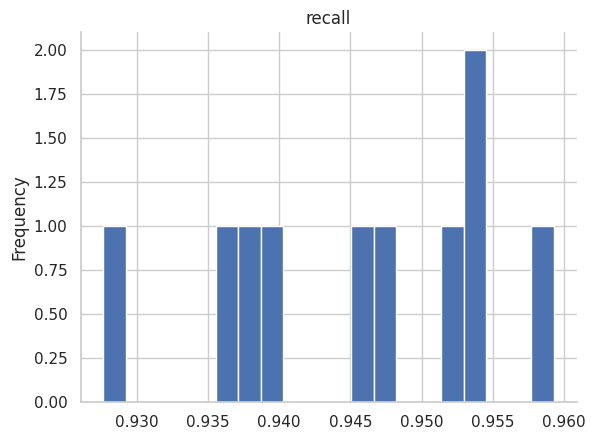

In [ ]:
from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)